## Skip Grammars - Contiunuous Bag Of Words

This NLP technic take in consideration the order in wich the words are located in to the text.
The main goal is understand how the words connect to each other and therefore the meaning of the phrase.

i.e:
- King - man + woman = Queen
- Indian Pale Ale - hops + malta = Stout

A word is predicted (Queen - Stout) using only the words and their relationship in the phrase. This technic in named  Continuous Bag of words.

If we want to predict the words surrounding a specific word then Skip Grammar is the technic to use.


#### Movies Review Analysis

Based on a huge dataset of movie reviews we're going to classify if the kind of movie that the person saw:
[cliche, love, hate, silly, sad] are the available categories.

Library import

In [1]:
import requests
import io
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import string
import collections
import tarfile
import urllib.request
import nltk
from nltk.corpus import stopwords

session = tf.Session()
%config Completer.use_jedi = False 

Constant definition

In [2]:
batch_size = 50
embedding_size = 200  
vocabulary_size = 10000    #Words to consider 
generations = 50000    #Training iterations
print_loss_every = 500
num_sampled = int(batch_size/2)
window_size = 2   #Number of possibilities for the result
stops = stopwords.words('english')   #stopwords import
print_valid_every = 2000
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']   #Goal words to predict
url = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'   #Dataset URL

Dataset import


In [3]:
def load_movies_data():
    save_folder_name = '../../Datasets/movies_data'
    pos_file = os.path.join(save_folder_name, 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polarity.neg')
    
    if os.path.exists(save_folder_name):
        #We can import directly the dataset
        pos_data = []
        with open(pos_file, 'r') as temp_pos_file:
            for row in temp_pos_file:
                pos_data.append(row)
        neg_data = []
        with open(neg_file, 'r') as temp_neg_file:
            for row in temp_neg_file:
                neg_data.append(row)
        
    else: 
        #Firts we need to download the data then import the dataset
        stream_data = urllib.request.urlopen(url)
        tmp = io.BytesIO()
        while True:
            s = stream_data.read(16384)
            if not s:
                break
            tmp.write(s)
        stream_data.close()
        tpm.seek(0)
        tar_file = tarfile.open(fileobj = tmp, mode = 'r:gz')
        pos = tar_file.extractfile('rt-polaritydata/rt-polarity.pos')
        neg = tar_file.extractfile('rt-polaritydata/rt-polarity.neg')
        pos_data = []
        for line in pos:
            pos_data.append(line.decode('ISO-8859-1').encode('ascii', errors = 'ignore').decode())
        neg_data = []
        for line in neg:
            neg_data.append(line.decode('ISO-8859-1').encode('ascii', errors = 'ignore').decode())   
        
        tar_file.close()
        
        if not os.path.exists(save_folder_name):
            os.makedirs(save_folder_name)
        with open(pos_file, 'w') as pos_file_handler:
            pos_file_handler.write(''.join(pos_data))
        with open(neg_file, 'w') as neg_file_handler:
            neg_file_handler.write(''.join(pos_data))
    
    texts = pos_data + neg_data
    target = [1]*len(pos_data)+[0]*len(neg_data)
    
    return(texts, target)

In [4]:
texts, target = load_movies_data()

### Data preprocessing
- Number eliminiation
- Lowercase convertion
- Puntuation elimination
- White spaces trim

In [5]:
def normalize_text(texts, stop):
    texts = [x.lower() for x in texts]  #Lowercase convertion
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]  #Punctuation deleting
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]  #Numbers deleting
    texts = [' '.join(word for word in x.split() if word not in (stop)) for x in texts]  #White space omition
    texts = [' '.join(x.split()) for x in texts]
    return texts

In [6]:
texts = normalize_text(texts, stops)

- Text lenght analysis.

We omit the data with less than 2 words

In [7]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>2]
texts = [x for x in texts if len(x.split())>2]

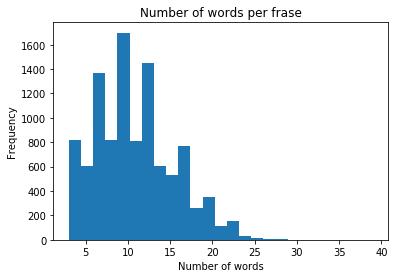

In [8]:
texts_lenghts = [len(x.split()) for x in texts]
texts_lenghts = [x for x in texts_lenghts]  # Delete messages with a lengh of more than 50 words
plt.hist(texts_lenghts, bins = 25)
plt.title('Number of words per frase')
plt.ylabel('Frequency')
plt.xlabel('Number of words')
plt.show()

- Dictionary build.

A frequency-based dictionary is needed. This will give us a list of the most used words in our dataset. For words out of the $vocabulary size$ restriction a 'RARE' label will be used.

In [9]:
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]   #Split of phrases in to words
    words = [x for sublist in split_sentences for x in sublist] #Split of list of words in to a one list of words
    count = [['RARE', -1]] #First category of dictionary is RARE with frecuency -1
    count.extend(collections.Counter(words).most_common(vocabulary_size -1))
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)  
    return word_dict

In [10]:
word_dict = build_dictionary(texts, vocabulary_size)

In [11]:
word_dict['good']

8

- Phrase to number.

This function convert every word-based sentence/phrase in to a array with the same size as the number of words in the sentence where the number is de ID or position of the word in the dictionary.

In [12]:
def text_to_number(sentences, word_dict):
    data = []
    for sentence in sentences:   #For every sentence in the dataset
        sentence_data = []
        for word in sentence:        #For every word in that sentece
            if word in word_dict:          #If the word is in the dictionary
                word_ix = word_dict[word]      #Word position/ID in word dict
            else:
                word_ix = 0 #Word position/ID for RARE words
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data

In [13]:
word_dict_rev = dict(zip(word_dict.values(), word_dict.keys()))

text_data = text_to_number(texts, word_dict)   # text to dictionary ID convertion
valid_examples = [word_dict[x] for x in valid_words]   #Same but with the target words

- Batch data selection.

The algorithm input is

In [14]:
def generate_batch_data(sentences, batch_size, window_size, method = 'skip_gram'):
    """
    Algorithm example:
    
    Mi perro come su comida -> (Mi, come), (perro, come), (su, come), (comida, come)
    """
    
    batch_data = []
    label_data = []
    
    while len(batch_data) < batch_size:
        rand_sentences = np.random.choice(sentences)
        window_seq = [rand_sentences[max((ix - window_size),0) : (ix+window_size+1)] for ix, x in enumerate(rand_sentences)]
        label_idx = [ix if ix < window_size else window_size for ix, x in enumerate(window_seq)]
        
        if method == 'skip_gram':
            batch_and_labels = [(x[y], x[:y]+x[(y+1):]) for x,y in zip(window_seq, label_idx)]
            tuple_data = [(x,y_) for x, y in batch_and_labels for y_ in y]
        else:
            raise ValueError('{} Method is not implemented'.format(method))
        batch, labels = [list(x) for x in zip(*tuple_data)]
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return(batch_data, label_data)

## Train with Skip Grammars

Tensorflow Variable declaration

- Global variables

In [15]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1, 1))
x_inputs = tf.placeholder( shape = [batch_size] , dtype =tf.int32)
y_target = tf.placeholder(shape = [batch_size, 1], dtype = tf.int32)
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)

- Sparsed Lookup matrix

In [16]:
embed = tf.nn.embedding_lookup(embeddings, x_inputs)

- Noise contrastive Error.

This Error function allows to use sparsed vectors (mostly filled with zeros) without convergence issues.


In [17]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],    #size
                                              stddev = 1.0/np.sqrt(embedding_size)))  #standard deviation initialization
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

- Loss Function

Using NCE for the error measurement

In [18]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights= nce_weights, biases= nce_biases,
                                    inputs = embed, labels = y_target,
                                    num_sampled = num_sampled, num_classes = vocabulary_size))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



To find similarity between the validation words and the actual words we use a Cosine distance Norm.
https://es.wikipedia.org/wiki/Similitud_coseno

In [19]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims = True))   #Norm of embeddings
normalized_embeddings = embeddings/norm                                      #Embeddings normalization 
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  #Lookup vector of the normalized embeddings over the valid words
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b = True)  #Similarity evaluation

- Gradient Descendent Optimizer

In [20]:
learning_rate = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate= learning_rate).minimize(loss)

- Variable initialization

In [25]:
init = tf.global_variables_initializer()
session.run(init)

#### Training Loop

In [29]:
loss_vect = []
loss_x_vect = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size, window_size)
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    session.run(optimizer, feed_dict=feed_dict)
    
    if (i+1) % print_loss_every == 0:
        loss_val = session.run(loss, feed_dict=feed_dict)
        loss_vect.append(loss_val)
        loss_x_vect.append(i+1)
        print("Step #{}, Loss: {}".format(i+1, loss_val))
    
    ## Validación de palabras más cercanas a las 5 seleccionadas
    if (i+1) % print_valid_every == 0:
        sim = session.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dict_rev[valid_examples[j]]
            top_k = 10
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_string = "Nearest Words to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dict_rev[nearest[k]]
                log_string = "%s %s, "%(log_string, close_word)
            print(log_string)

/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Iteración 500, Pérdida: 
Iteración 1000, Pérdida: 
Iteración 1500, Pérdida: 
Iteración 2000, Pérdida: 
Palabras cercanas a cliche: africanamericans,  blanks,  quieter,  ring,  entry,  modesty,  preachy,  amuse,  boring,  follows, 
Palabras cercanas a love: inquiry,  imitation,  decline,  feral,  conditioning,  tensions,  effort,  elemento,  puerile,  awkward, 
Palabras cercanas a hate: hinton,  clare,  rising,  vain,  veteran,  releasing,  virtually,  precisely,  hightech,  hundred, 
Palabras cercanas a silly: kidnapping,  departs,  overstated,  executed,  tossed,  jealous,  christopher,  wendigo,  rest,  stretch, 
Palabras cercanas a sad: satin,  melodic,  minimalist,  biting,  abundance,  draws,  objects,  storys,  photographs,  inimitable, 
Iteración 2500, Pérdida: 
Iteración 3000, Pérdida: 
Iteración 3500, Pérdida: 
Iteración 4000, Pérdida: 
Palabras cercanas a cliche: africanamericans,  blanks,  quieter,  ring,  entry,  modesty,  preachy,  amuse,  boring,  follows, 
Palabras cerca

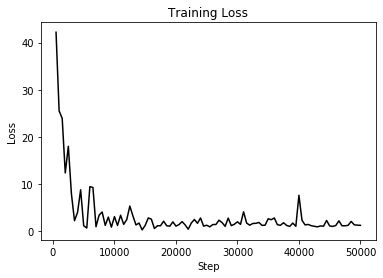

In [32]:
plt.plot(loss_x_vect, loss_vect, 'k-')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()